# QAOA landscape analysis

This notebook demos some of the features for analysing QAOA cost function landscapes. A landscape is generated by iterating over a range of different values of a given set of parameters of interest (denoted `sweep` parameters), keeping all other parameters fixed (denoted `fixed` parameters). The cost function (and possibly its standard deviation) are computed for all combinations of the `sweep` parameters.

The `landscapes` class then provides the ability to perform a range of analyses on the generated landscape (stored as an ndarray):

1) Visualise the landscape of the cost function and its standard deviation when sweeping over one or two of the parameters, keeping all others fixed.

2) Statistical features of the landscape, including the number of maxima, minima, their heights, separations, etc.

3) Compare two different landscapes.

4) ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Type, Iterable

# import the neccesary pyquil modules
from qaoa.cost_function import QAOACostFunctionOnWFSim
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters that we want to demo
from qaoa.parameters import AlternatingOperatorsQAOAParameters, AbstractQAOAParameters, GeneralQAOAParameters,\
QAOAParameterIterator
from vqe.optimizer import scipy_optimizer
import utilities as ut

import landscapes as lsc

## Landscape visualisation

Let's consider the simple problem we have looked at before. First set up the parameters: here we will use the `AlternatingOperators` class.

In [2]:
h1 = PauliSum.from_compact_str("0.7*Z0*Z1 + 1.2*Z0*Z2 + (-0.5)*Z0")
timesteps = 2

betas = np.random.rand(2,1)
gammas_singles = np.random.rand(2,1)
gammas_pairs = np.random.rand(2,1)

parameters = (betas,gammas_singles,gammas_pairs)

AltParams = AlternatingOperatorsQAOAParameters([h1,2],parameters)

Now specify the parameters we want to sweep over, and compute the cost function values using the `QAOAParameterIterator` class.

In [3]:
param1 = "betas[1]"
param2 = "gammas_pairs[0]"

range1 = np.linspace(0,2*np.pi,50)
range2 = np.linspace(0,np.pi,50)

sim = WavefunctionSimulator() # Define the wavefunction simulator

cost_vals = np.zeros((len(range1),len(range2)))
dev_vals = np.zeros((len(range1),len(range2)))

for i,p1 in zip(range(len(range1)),QAOAParameterIterator(AltParams, param1, range1)):
    for j,p2 in zip(range(len(range2)),QAOAParameterIterator(p1, param2, range2)):

        cost_function = QAOACostFunctionOnWFSim(h1,
                                            params=p2,
                                            sim=sim,
                                            return_standard_deviation=True,
                                            noisy=False,
                                            log=[])
    
    
        val,dev = cost_function(p2.raw())
        cost_vals[i,j] = val
        dev_vals[i,j] = dev   

We instantiate the landscape as an object as follows:

In [4]:
the_parameters = (param1,param2)
ranges = (range1,range2)
vals = (cost_vals,dev_vals)

landscape1 = lsc.landscape(the_parameters,ranges,vals)

Now we can plot the landscape in 3D. Note that since we have generated random values for all of the other parameters, the landscape generated here will be different each time.

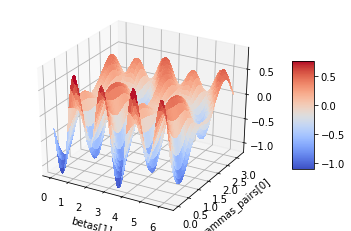

In [5]:
landscape1.plot_3D()

We can also plot a contour:

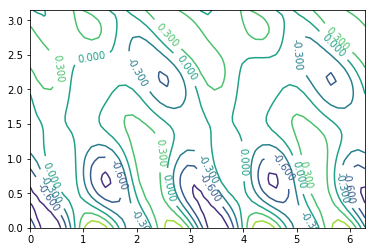

In [6]:
landscape1.plot_contour()

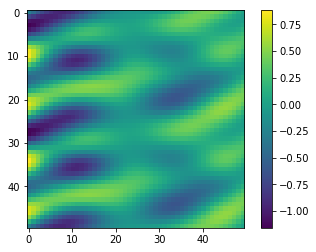

In [7]:
landscape1.plot_image()

## Landscape analysis

We can find the locations of the local minima as follows:

In [8]:
np.shape(landscape1.func_vals)

(50, 50)

In [9]:
minima = landscape1.get_local_minima()
len(landscape1.local_mins)

13

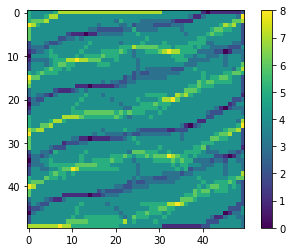

In [10]:
plt.imshow(landscape1.larger_neighbours)
plt.colorbar()
plt.show()

We can then plot values of the cost function at these minima.

-1.1591829147348336
(3, 0)


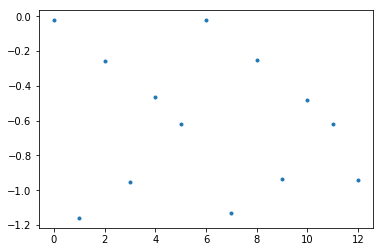

In [11]:
min_vals = [cost_vals[tuple(i)] for i in landscape1.local_mins]
print(min(min_vals))
print(landscape1.local_mins[np.argmin(min_vals)])

plt.plot(min_vals,'.')
plt.show()

With information on the location of local minima, we can go on to compute things like:

- the difference in cost function value with their neighbouring local maxima
- statistics (eg compare the number of local minima with properties of the Hamiltonian, the parametrisation, etc).

In [12]:
# Other plotting options:

# landscape1.plot_slice(opts) (for plotting a slice of the 3D)

# Other things we could do with the landscape (not necessarily visualisation)

# Compute/show gradients 
# Statistics, e.g. number of minima, maxima, their values, etc.
# Compare two different landscapes